## Домашнее задание : "Обучение с подкреплением"

ФИО: Лебедев Аркадий

# Задание 1

Обучите алгоритм Q-learning для сред FrozenLake-v1 и Blackjack-v1, в частности подберите оптимальную alpha. (2 балла)

In [4]:
import pickle
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import defaultdict


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
def run_frozenlake(config, q_table=None, is_train=True, render=False):
    render_mode = "human" if render else None
    env = gym.make("FrozenLake-v1", is_slippery=True, render_mode=render_mode)
    
    alpha = config["alpha"]
    gamma = config["gamma"]
    epsilon = config["epsilon"]
    epsilon_decay = config["epsilon_decay"]
    min_epsilon = config["min_epsilon"]
    num_episodes = config["num_episodes"]
    
    n_states = env.observation_space.n  # Например, 16 для 4x4 поля
    n_actions = env.action_space.n      # Например, 4 действия
    
    # Инициализируем Q-таблицу как тензор на устройстве
    if q_table is None:
        q_table = torch.zeros((n_states, n_actions), dtype=torch.float32, device=device)
    
    rewards_per_episode = np.zeros(num_episodes)
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        terminated = False
        truncated = False
        
        while not terminated and not truncated:
            if is_train and np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                # Выбор действия с максимальным Q-значением
                with torch.no_grad():
                    q_values = q_table[state]
                    action = torch.argmax(q_values).item()
            
            # Совершаем шаг
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            if is_train:
                # Обеспечиваем, что индексы находятся на устройстве
                state_tensor = torch.tensor(state, dtype=torch.long, device=device)
                next_state_tensor = torch.tensor(next_state, dtype=torch.long, device=device)
                action_tensor = torch.tensor(action, dtype=torch.long, device=device)
                reward_tensor = torch.tensor(reward, dtype=torch.float32, device=device)
                
                # Вычисляем TD target
                with torch.no_grad():
                    max_next_q = torch.max(q_table[next_state_tensor])
                    td_target = reward_tensor + gamma * max_next_q * (0 if terminated else 1)
                
                # Вычисляем TD delta
                td_delta = td_target - q_table[state_tensor, action_tensor]
                
                # Обновляем Q-значение
                q_table[state_tensor, action_tensor] += alpha * td_delta
            
            state = next_state
            rewards_per_episode[episode] += reward
        
        # Обновление epsilon
        if is_train:
            epsilon = max(epsilon - epsilon_decay, min_epsilon)
            if epsilon == min_epsilon:
                alpha *= 0.1  # Уменьшаем alpha при достижении минимального epsilon
        
        if (episode + 1) % 1000 == 0:
            print(f"Эпизод {episode + 1}/{num_episodes}, Epsilon: {epsilon:.4f}, Alpha: {alpha:.4f}")
    
    env.close()
    print("Обучение завершено для FrozenLake-v1!")
    
    window = 100
    sum_rewards = np.convolve(rewards_per_episode, np.ones(window), 'valid') / window
    
    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.plot(sum_rewards)
    plt.xlabel("Номер эпизода")
    plt.ylabel(f"Средняя награда за {window} эпизодов")
    plt.title("Обучение Q-learning на FrozenLake-v1")
    plt.grid(True)
    plt.savefig("frozen_lake.png")
    plt.show()
    
    return q_table.cpu(), sum_rewards  # Переносим на CPU для сохранения


In [7]:
def grid_search_frozenlake():
    alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
    gamma = 0.99
    epsilon = 1.0
    epsilon_decay = 0.0005
    min_epsilon = 0.01
    num_episodes = 10000
    
    scores = []
    for alpha in alphas:
        config = {
            "alpha": alpha,
            "gamma": gamma,
            "epsilon": epsilon,
            "epsilon_decay": epsilon_decay,
            "min_epsilon": min_epsilon,
            "num_episodes": num_episodes,
        }
        q_table, sum_rewards = run_frozenlake(config, is_train=True, render=False)
        mean_reward = sum_rewards[-1000:].mean()
        scores.append(mean_reward)
        print(f"alpha: {alpha}, средняя награда: {mean_reward:.4f}")
    
    # Визуализация результатов grid search
    plt.figure(figsize=(8, 4))
    plt.plot(alphas, scores, marker='o')
    plt.xlabel("Alpha")
    plt.ylabel("Средняя награда")
    plt.title("Grid Search для FrozenLake-v1")
    plt.grid(True)
    plt.savefig("frozen_lake_grid_search.png")
    plt.show()
    
    best_alpha = alphas[np.argmax(scores)]
    best_score = max(scores)
    print(f"Лучшее alpha: {best_alpha} со средней наградой {best_score:.4f}")


In [8]:
def save_q_table_frozenlake(q_table, filename="q_table_frozenlake.pkl"):
    q_table_np = q_table.numpy()
    with open(filename, "wb") as f:
        pickle.dump(q_table_np, f)

def load_q_table_frozenlake(filename="q_table_frozenlake.pkl"):
    with open(filename, "rb") as f:
        q_table_np = pickle.load(f)
    return torch.tensor(q_table_np, dtype=torch.float32, device=device)


Эпизод 1000/10000, Epsilon: 0.5000, Alpha: 0.3000
Эпизод 2000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 3000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 4000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 5000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 6000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 7000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 8000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 9000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 10000/10000, Epsilon: 0.0100, Alpha: 0.0000
Обучение завершено для FrozenLake-v1!


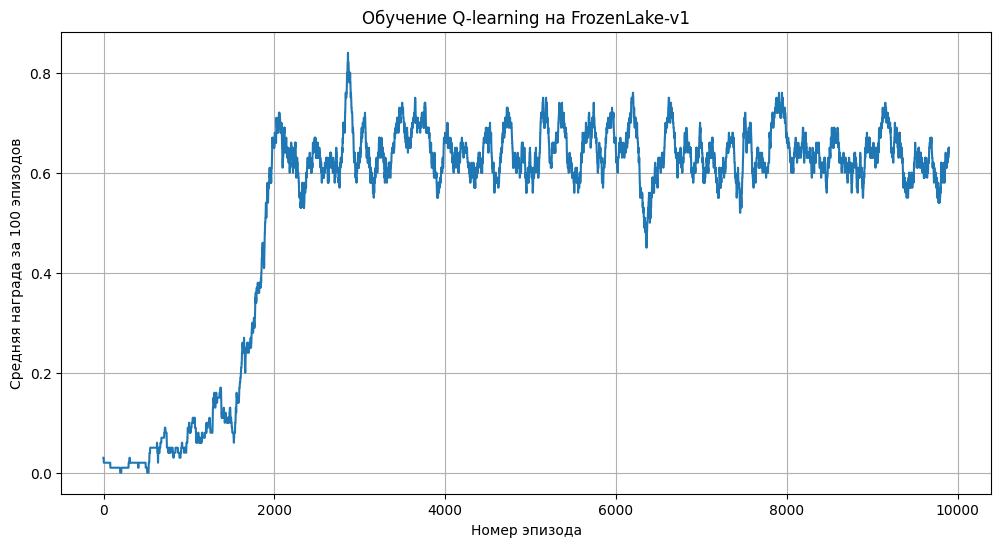

Эпизод 1000/10000, Epsilon: 0.5000, Alpha: 0.1000
Эпизод 2000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 3000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 4000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 5000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 6000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 7000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 8000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 9000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 10000/10000, Epsilon: 0.0100, Alpha: 0.0000
Обучение завершено для FrozenLake-v1!


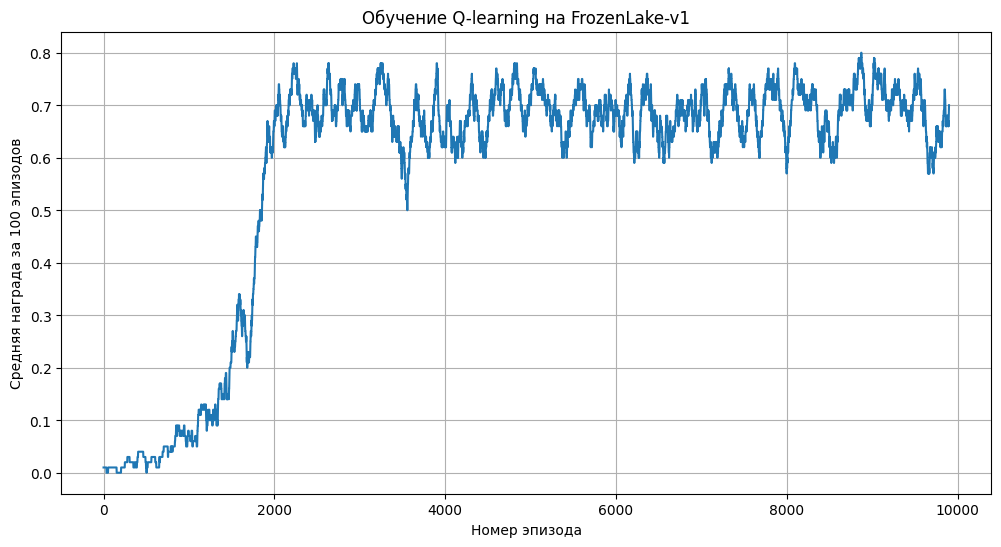

alpha: 0.1, средняя награда: 0.6925
Эпизод 1000/10000, Epsilon: 0.5000, Alpha: 0.2000
Эпизод 2000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 3000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 4000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 5000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 6000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 7000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 8000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 9000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 10000/10000, Epsilon: 0.0100, Alpha: 0.0000
Обучение завершено для FrozenLake-v1!


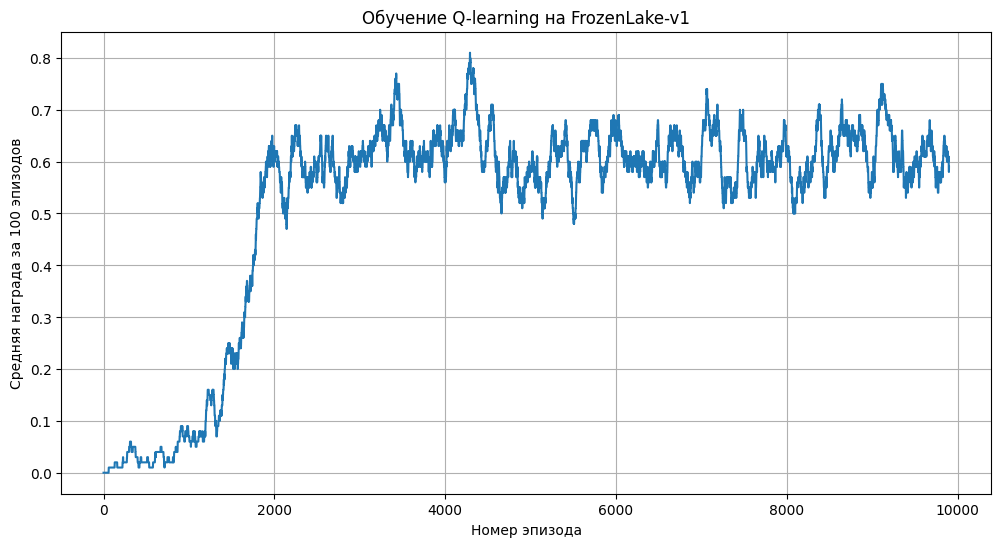

alpha: 0.2, средняя награда: 0.6162
Эпизод 1000/10000, Epsilon: 0.5000, Alpha: 0.3000
Эпизод 2000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 3000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 4000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 5000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 6000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 7000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 8000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 9000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 10000/10000, Epsilon: 0.0100, Alpha: 0.0000
Обучение завершено для FrozenLake-v1!


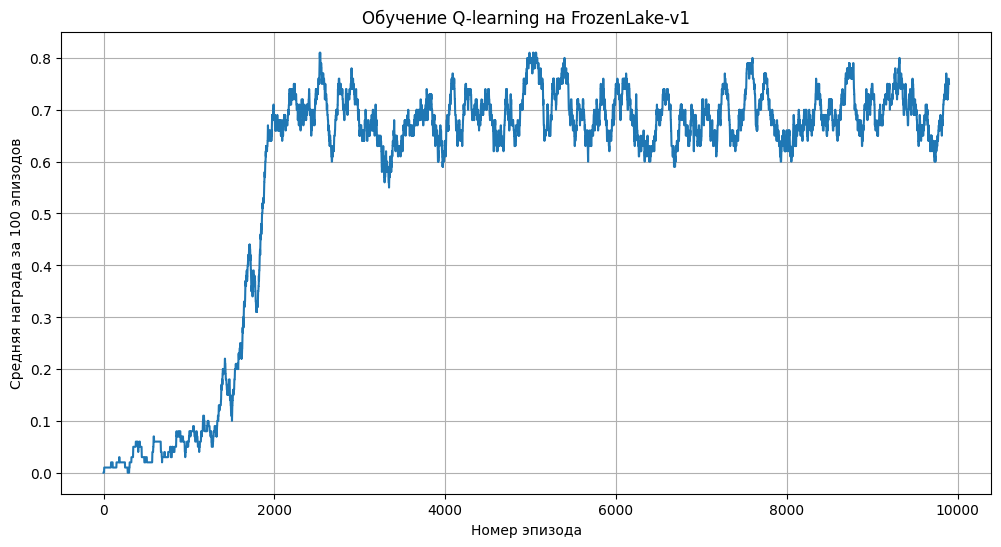

alpha: 0.3, средняя награда: 0.6998
Эпизод 1000/10000, Epsilon: 0.5000, Alpha: 0.4000
Эпизод 2000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 3000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 4000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 5000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 6000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 7000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 8000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 9000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 10000/10000, Epsilon: 0.0100, Alpha: 0.0000
Обучение завершено для FrozenLake-v1!


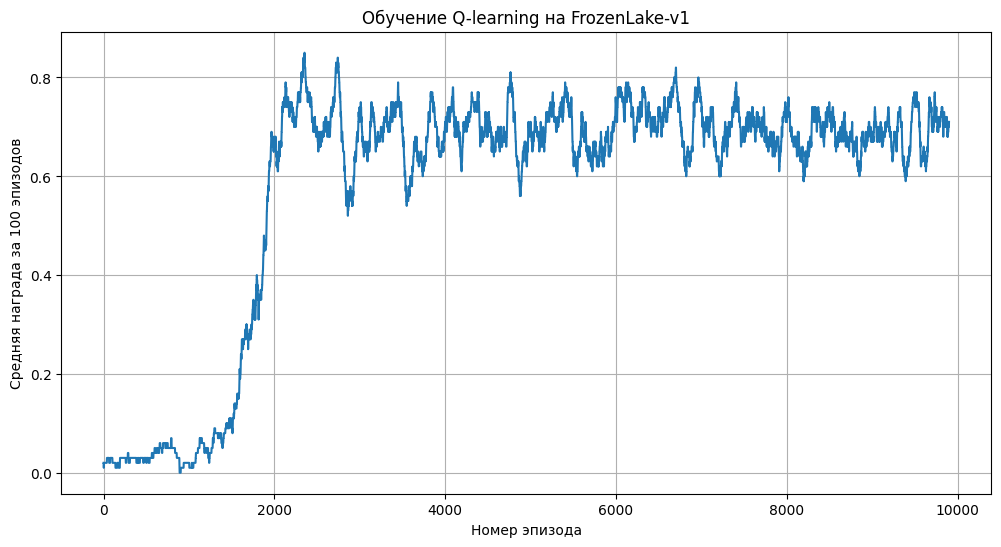

alpha: 0.4, средняя награда: 0.6899
Эпизод 1000/10000, Epsilon: 0.5000, Alpha: 0.5000
Эпизод 2000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 3000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 4000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 5000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 6000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 7000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 8000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 9000/10000, Epsilon: 0.0100, Alpha: 0.0000
Эпизод 10000/10000, Epsilon: 0.0100, Alpha: 0.0000
Обучение завершено для FrozenLake-v1!


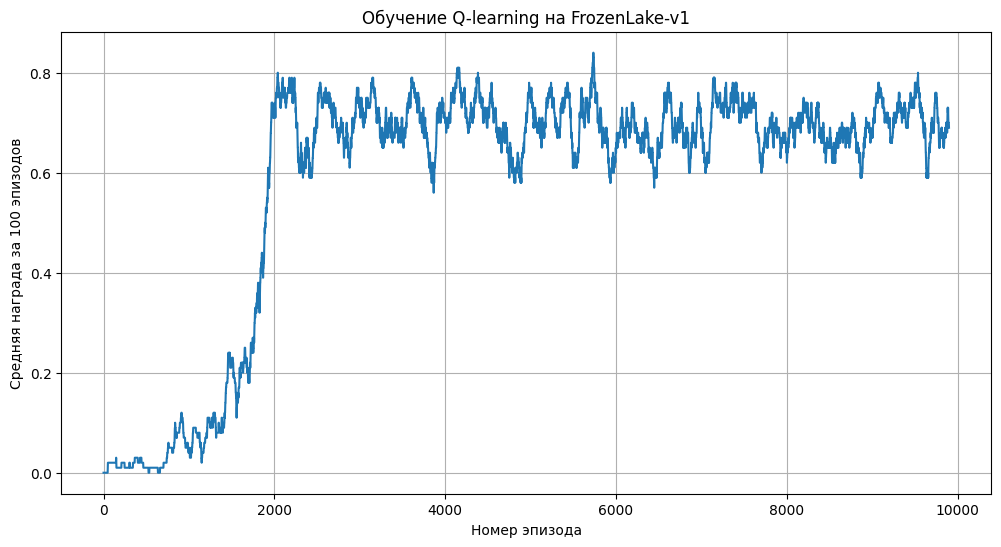

alpha: 0.5, средняя награда: 0.7079


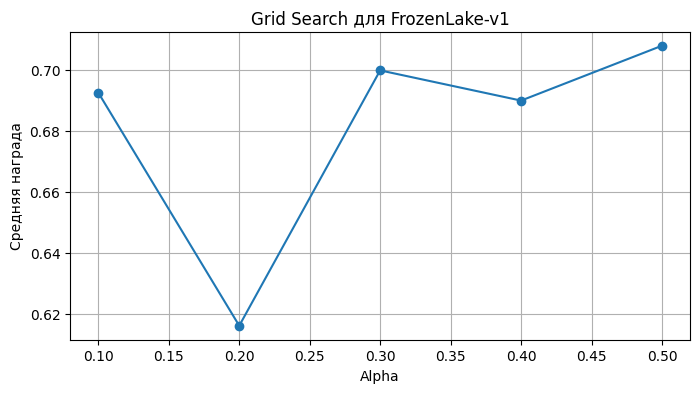

Лучшее alpha: 0.5 со средней наградой 0.7079


In [10]:
if __name__ == "__main__":
    config_frozenlake = {
        "alpha": 0.3,
        "gamma": 0.99,
        "epsilon": 1.0,
        "epsilon_decay": 0.0005,
        "min_epsilon": 0.01,
        "num_episodes": 10000,
    }
    q_table_fl, sum_rewards_fl = run_frozenlake(config_frozenlake, is_train=True, render=False)
    
    # Сохранение Q-таблицы для FrozenLake
    save_q_table_frozenlake(q_table_fl, "q_table_frozenlake.pkl")
    
    # Запуск grid search для подбора оптимального alpha
    grid_search_frozenlake()


In [16]:
def state_to_index_blackjack(state):
    player_sum, dealer_card, usable_ace = state
    if player_sum < 4 or player_sum > 21:
        return None
    idx_player = player_sum - 4    
    idx_dealer = dealer_card - 1    
    idx_ace = 1 if usable_ace else 0
    return idx_player * 20 + idx_dealer * 2 + idx_ace  

In [17]:
def run_blackjack(config, q_table=None, is_train=True, render=False):
    render_mode = "human" if render else None
    env = gym.make("Blackjack-v1", sab=True, render_mode=render_mode)
    
    alpha = config["alpha"]
    gamma = config["gamma"]
    epsilon = config["epsilon"]
    epsilon_decay = config["epsilon_decay"]
    min_epsilon = config["min_epsilon"]
    num_episodes = config["num_episodes"]
    
    n_actions = env.action_space.n  # 2 действия: hit=0, stick=1
    n_states = 360  # Всего уникальных состояний
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    q_table_device = device
    
    if q_table is None:
        q_table = torch.zeros((n_states, n_actions), dtype=torch.float32, device=device)
    else:
        q_table = q_table.to(device)
    
    rewards_per_episode = np.zeros(num_episodes)
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        terminated = False
        truncated = False
        
        while not terminated and not truncated:
            state_idx = state_to_index_blackjack(state)
            
            if state_idx is None:
                break
            
            if is_train and np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                # Выбор действия с максимальным Q-значением
                with torch.no_grad():
                    q_values = q_table[state_idx]
                    action = torch.argmax(q_values).item()
            
            # Совершаем шаг
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            if is_train:
                next_state_idx = state_to_index_blackjack(next_state)
                
                if not terminated and not truncated and next_state_idx is not None:
                    with torch.no_grad():
                        max_next_q = torch.max(q_table[next_state_idx])
                else:
                    max_next_q = torch.tensor(0.0, device=device)
                
                # Обновляем Q-значение
                td_target = torch.tensor(reward, dtype=torch.float32, device=device) + gamma * max_next_q
                td_delta = td_target - q_table[state_idx, action]
                q_table[state_idx, action] += alpha * td_delta
            
            state = next_state
            rewards_per_episode[episode] += reward
        
        # Обновление epsilon
        if is_train:
            epsilon = max(epsilon - epsilon_decay, min_epsilon)
            if epsilon == min_epsilon:
                alpha *= 0.1  # Уменьшаем alpha при достижении минимального epsilon
        
        if (episode + 1) % 1000 == 0:
            print(f"Эпизод {episode + 1}/{num_episodes}, Epsilon: {epsilon:.4f}, Alpha: {alpha:.4f}")
    
    env.close()
    print("Обучение завершено для Blackjack-v1!")
    
    window = 100
    sum_rewards = np.convolve(rewards_per_episode, np.ones(window), 'valid') / window
    
    plt.figure(figsize=(12, 6))
    plt.plot(sum_rewards)
    plt.xlabel("Номер эпизода")
    plt.ylabel(f"Средняя награда за {window} эпизодов")
    plt.title("Обучение Q-learning на Blackjack-v1")
    plt.grid(True)
    plt.savefig("blackjack.png")
    plt.show()
    
    return q_table.cpu(), sum_rewards  

In [18]:
def grid_search_blackjack():
    alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
    gamma = 1.0
    epsilon = 1.0
    epsilon_decay = 0.0001
    min_epsilon = 0.001
    num_episodes = 15000
    
    scores = []
    for alpha in alphas:
        config = {
            "alpha": alpha,
            "gamma": gamma,
            "epsilon": epsilon,
            "epsilon_decay": epsilon_decay,
            "min_epsilon": min_epsilon,
            "num_episodes": num_episodes,
        }
        q_table, sum_rewards = run_blackjack(config, is_train=True, render=False)
        mean_reward = sum_rewards[-1000:].mean()
        scores.append(mean_reward)
        print(f"alpha: {alpha}, средняя награда: {mean_reward:.4f}")
    
    plt.figure(figsize=(8, 4))
    plt.plot(alphas, scores, marker='o')
    plt.xlabel("Alpha")
    plt.ylabel("Средняя награда")
    plt.title("Grid Search для Blackjack-v1")
    plt.grid(True)
    plt.savefig("blackjack_grid_search.png")
    plt.show()
    
    best_alpha = alphas[np.argmax(scores)]
    best_score = max(scores)
    print(f"Лучшее alpha: {best_alpha} со средней наградой {best_score:.4f}")


In [19]:

def save_q_table_blackjack(q_table, filename="q_table_blackjack.pkl"):
    q_table_np = q_table.numpy()
    with open(filename, "wb") as f:
        pickle.dump(q_table_np, f)

def load_q_table_blackjack(filename="q_table_blackjack.pkl"):
    with open(filename, "rb") as f:
        q_table_np = pickle.load(f)
    return torch.tensor(q_table_np, dtype=torch.float32, device=device)


Эпизод 1000/15000, Epsilon: 0.9000, Alpha: 0.6000
Эпизод 2000/15000, Epsilon: 0.8000, Alpha: 0.6000
Эпизод 3000/15000, Epsilon: 0.7000, Alpha: 0.6000
Эпизод 4000/15000, Epsilon: 0.6000, Alpha: 0.6000
Эпизод 5000/15000, Epsilon: 0.5000, Alpha: 0.6000
Эпизод 6000/15000, Epsilon: 0.4000, Alpha: 0.6000
Эпизод 7000/15000, Epsilon: 0.3000, Alpha: 0.6000
Эпизод 8000/15000, Epsilon: 0.2000, Alpha: 0.6000
Эпизод 9000/15000, Epsilon: 0.1000, Alpha: 0.6000
Эпизод 10000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 11000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 12000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 13000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 14000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 15000/15000, Epsilon: 0.0010, Alpha: 0.0000
Обучение завершено для Blackjack-v1!


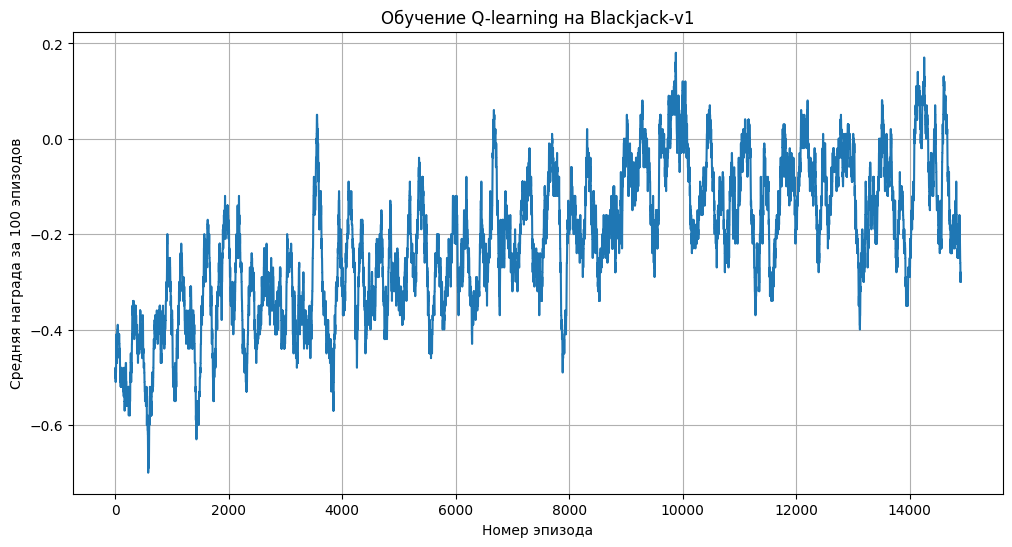

Эпизод 1000/15000, Epsilon: 0.9000, Alpha: 0.1000
Эпизод 2000/15000, Epsilon: 0.8000, Alpha: 0.1000
Эпизод 3000/15000, Epsilon: 0.7000, Alpha: 0.1000
Эпизод 4000/15000, Epsilon: 0.6000, Alpha: 0.1000
Эпизод 5000/15000, Epsilon: 0.5000, Alpha: 0.1000
Эпизод 6000/15000, Epsilon: 0.4000, Alpha: 0.1000
Эпизод 7000/15000, Epsilon: 0.3000, Alpha: 0.1000
Эпизод 8000/15000, Epsilon: 0.2000, Alpha: 0.1000
Эпизод 9000/15000, Epsilon: 0.1000, Alpha: 0.1000
Эпизод 10000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 11000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 12000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 13000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 14000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 15000/15000, Epsilon: 0.0010, Alpha: 0.0000
Обучение завершено для Blackjack-v1!


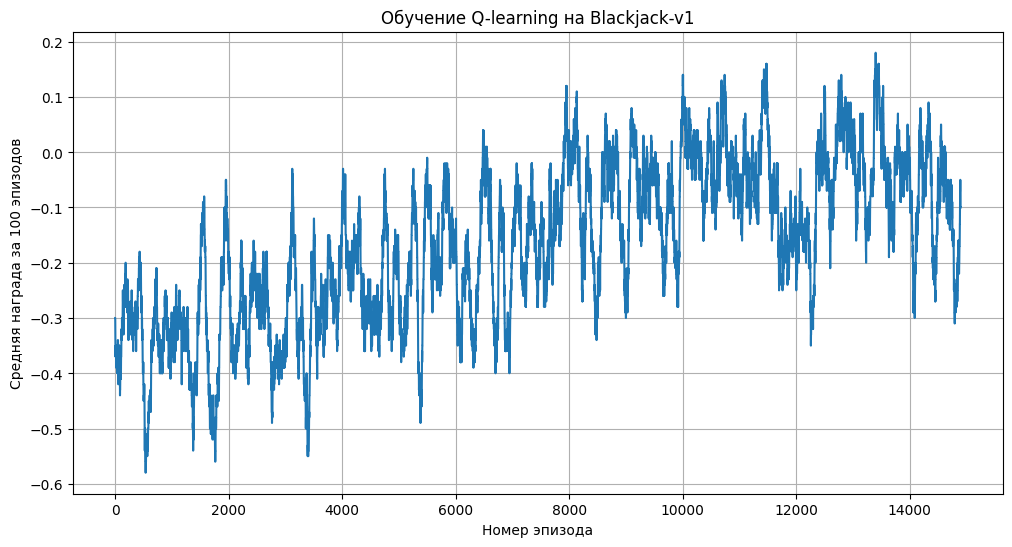

alpha: 0.1, средняя награда: -0.0912
Эпизод 1000/15000, Epsilon: 0.9000, Alpha: 0.2000
Эпизод 2000/15000, Epsilon: 0.8000, Alpha: 0.2000
Эпизод 3000/15000, Epsilon: 0.7000, Alpha: 0.2000
Эпизод 4000/15000, Epsilon: 0.6000, Alpha: 0.2000
Эпизод 5000/15000, Epsilon: 0.5000, Alpha: 0.2000
Эпизод 6000/15000, Epsilon: 0.4000, Alpha: 0.2000
Эпизод 7000/15000, Epsilon: 0.3000, Alpha: 0.2000
Эпизод 8000/15000, Epsilon: 0.2000, Alpha: 0.2000
Эпизод 9000/15000, Epsilon: 0.1000, Alpha: 0.2000
Эпизод 10000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 11000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 12000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 13000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 14000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 15000/15000, Epsilon: 0.0010, Alpha: 0.0000
Обучение завершено для Blackjack-v1!


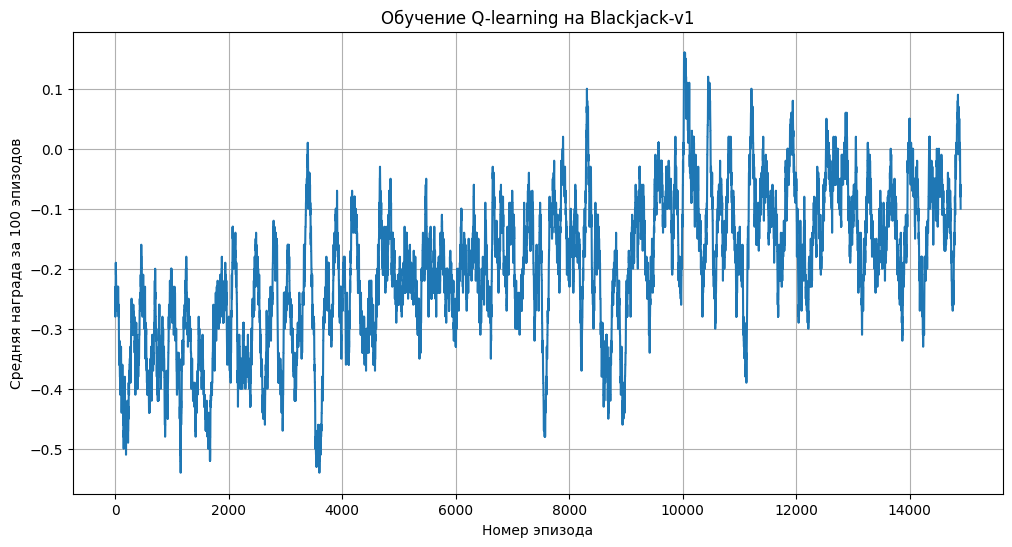

alpha: 0.2, средняя награда: -0.0998
Эпизод 1000/15000, Epsilon: 0.9000, Alpha: 0.3000
Эпизод 2000/15000, Epsilon: 0.8000, Alpha: 0.3000
Эпизод 3000/15000, Epsilon: 0.7000, Alpha: 0.3000
Эпизод 4000/15000, Epsilon: 0.6000, Alpha: 0.3000
Эпизод 5000/15000, Epsilon: 0.5000, Alpha: 0.3000
Эпизод 6000/15000, Epsilon: 0.4000, Alpha: 0.3000
Эпизод 7000/15000, Epsilon: 0.3000, Alpha: 0.3000
Эпизод 8000/15000, Epsilon: 0.2000, Alpha: 0.3000
Эпизод 9000/15000, Epsilon: 0.1000, Alpha: 0.3000
Эпизод 10000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 11000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 12000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 13000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 14000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 15000/15000, Epsilon: 0.0010, Alpha: 0.0000
Обучение завершено для Blackjack-v1!


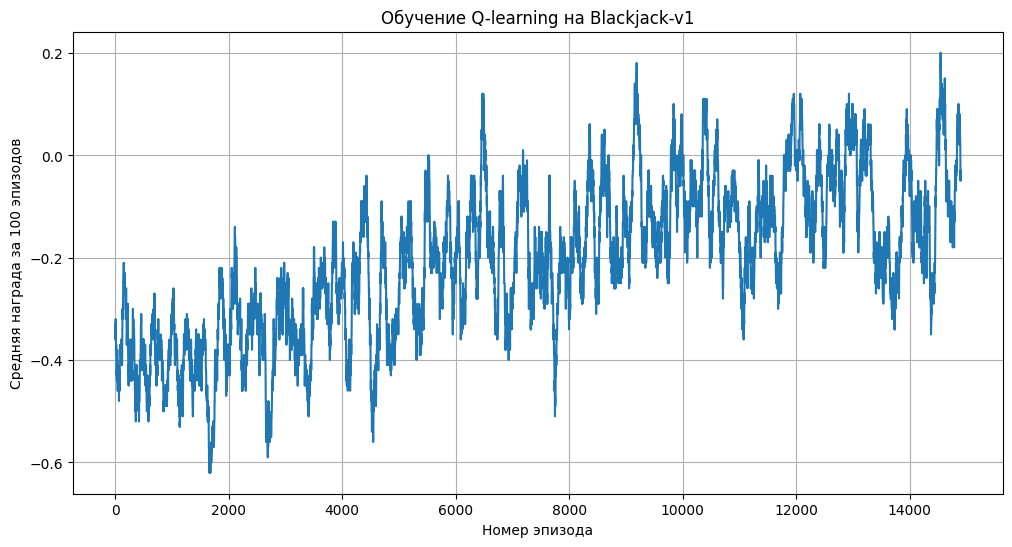

alpha: 0.3, средняя награда: -0.0748
Эпизод 1000/15000, Epsilon: 0.9000, Alpha: 0.4000
Эпизод 2000/15000, Epsilon: 0.8000, Alpha: 0.4000
Эпизод 3000/15000, Epsilon: 0.7000, Alpha: 0.4000
Эпизод 4000/15000, Epsilon: 0.6000, Alpha: 0.4000
Эпизод 5000/15000, Epsilon: 0.5000, Alpha: 0.4000
Эпизод 6000/15000, Epsilon: 0.4000, Alpha: 0.4000
Эпизод 7000/15000, Epsilon: 0.3000, Alpha: 0.4000
Эпизод 8000/15000, Epsilon: 0.2000, Alpha: 0.4000
Эпизод 9000/15000, Epsilon: 0.1000, Alpha: 0.4000
Эпизод 10000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 11000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 12000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 13000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 14000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 15000/15000, Epsilon: 0.0010, Alpha: 0.0000
Обучение завершено для Blackjack-v1!


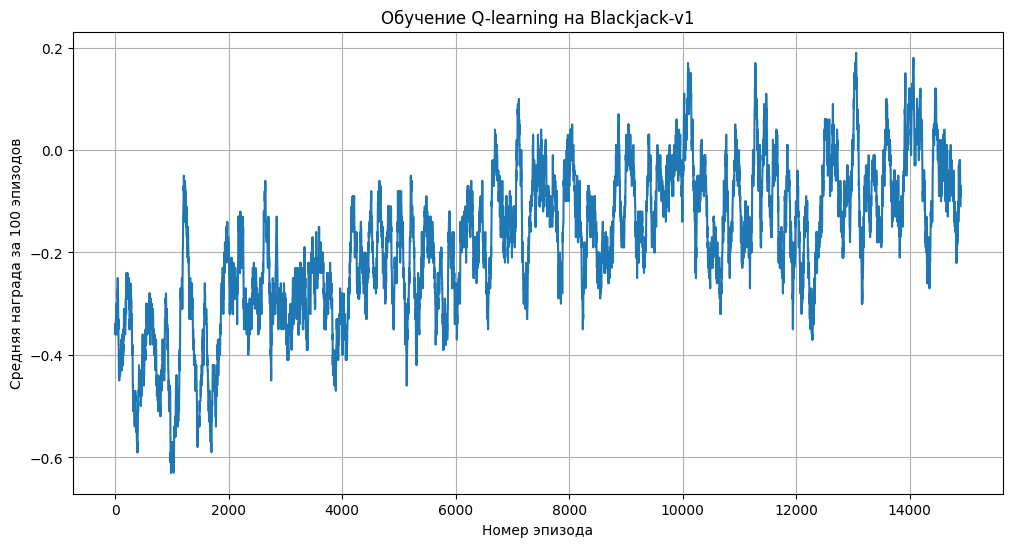

alpha: 0.4, средняя награда: -0.0334
Эпизод 1000/15000, Epsilon: 0.9000, Alpha: 0.5000
Эпизод 2000/15000, Epsilon: 0.8000, Alpha: 0.5000
Эпизод 3000/15000, Epsilon: 0.7000, Alpha: 0.5000
Эпизод 4000/15000, Epsilon: 0.6000, Alpha: 0.5000
Эпизод 5000/15000, Epsilon: 0.5000, Alpha: 0.5000
Эпизод 6000/15000, Epsilon: 0.4000, Alpha: 0.5000
Эпизод 7000/15000, Epsilon: 0.3000, Alpha: 0.5000
Эпизод 8000/15000, Epsilon: 0.2000, Alpha: 0.5000
Эпизод 9000/15000, Epsilon: 0.1000, Alpha: 0.5000
Эпизод 10000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 11000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 12000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 13000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 14000/15000, Epsilon: 0.0010, Alpha: 0.0000
Эпизод 15000/15000, Epsilon: 0.0010, Alpha: 0.0000
Обучение завершено для Blackjack-v1!


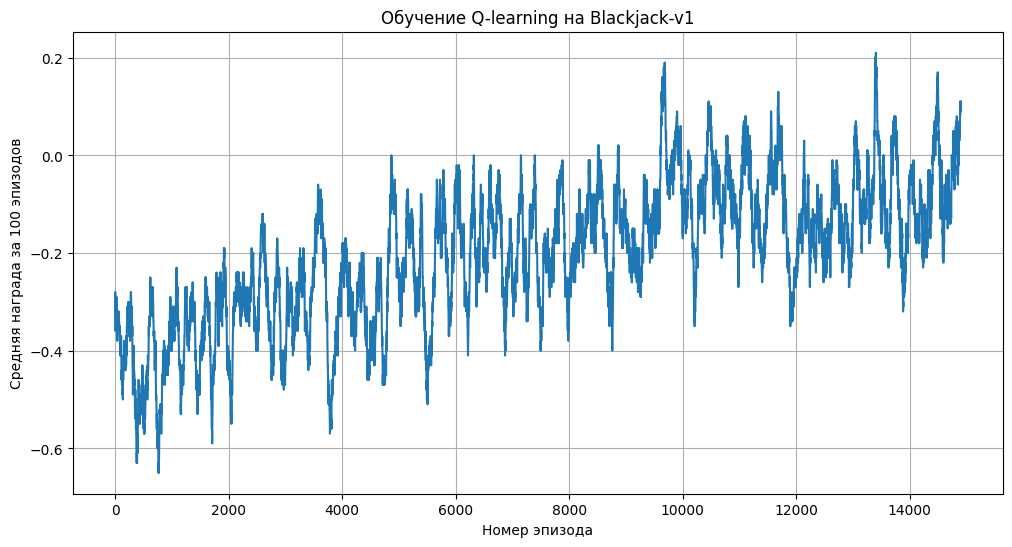

alpha: 0.5, средняя награда: -0.0765


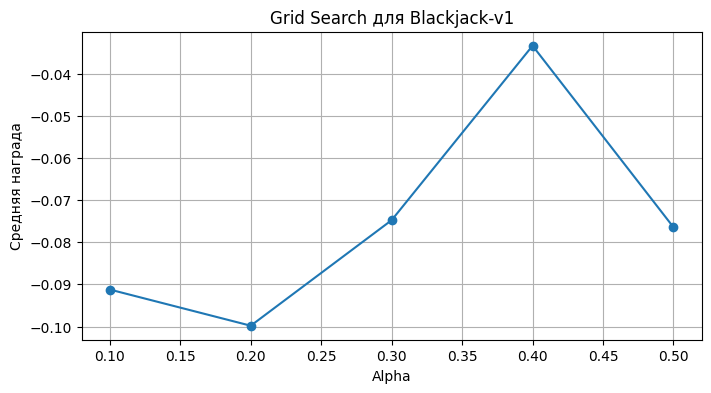

Лучшее alpha: 0.4 со средней наградой -0.0334


In [20]:
if __name__ == "__main__":
    config_blackjack = {
        "alpha": 0.6,
        "gamma": 1.0,
        "epsilon": 1.0,
        "epsilon_decay": 0.0001,
        "min_epsilon": 0.001,
        "num_episodes": 15000,
    }
    q_table_bj, sum_rewards_bj = run_blackjack(config_blackjack, is_train=True, render=False)

    save_q_table_blackjack(q_table_bj, "q_table_blackjack.pkl")
    
    grid_search_blackjack()


# Задание 2

Обучите алгоритм Policy Gradients (или Actor Critic) для среды https://www.gymlibrary.dev/environments/atari/breakout/ . Продемонстрируйте, что для обученного агента растет время игры. (3 балла)

In [44]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from tqdm import trange

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [46]:
class ActorCriticNetDiscrete(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCriticNetDiscrete, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
        )
        self.policy = nn.Linear(128, action_dim)
        self.value = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.fc(x)
        policy_logits = self.policy(x)
        value = self.value(x)
        return policy_logits, value


In [48]:
class ActorCriticNetContinuous(nn.Module):
    def __init__(self, state_dim, action_dim, action_bound):
        super(ActorCriticNetContinuous, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
        )
        self.mu = nn.Linear(128, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))

        self.value = nn.Linear(128, 1)
        self.action_bound = action_bound
    
    def forward(self, x):
        x = self.fc(x)
        mu = self.mu(x)
        std = torch.exp(self.log_std)
        value = self.value(x)
        return mu, std, value


In [49]:
def a2c_train_discrete(env_name, num_actions, state_dim, max_episodes=1000, rollout_steps=5, gamma=0.99, lr=1e-3):
    env = gym.make(env_name)
    net = ActorCriticNetDiscrete(state_dim, num_actions).to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    episode_rewards = []
    episode_lengths = []
    
    for episode in trange(max_episodes, desc="Training Episodes"):
        state, info = env.reset()
        done = False
        truncated = False
        ep_reward = 0.0
        ep_length = 0
        
        states = []
        actions = []
        rewards = []
        values = []
        log_probs = []
        
        while not done and not truncated:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
            logits, value = net(state_tensor)
            probs = torch.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            
            next_state, reward, done, truncated, info = env.step(action.item())
            
            states.append(state_tensor)
            actions.append(action)
            rewards.append(reward)
            values.append(value.squeeze())
            log_probs.append(log_prob)
            
            ep_reward += reward
            ep_length += 1
            state = next_state
            
            # Если собрали enough steps для обновления
            if len(states) >= rollout_steps:
                with torch.no_grad():
                    _, next_value = net(torch.tensor(state, dtype=torch.float32, device=device))
                    next_value = next_value.squeeze()
                returns = []
                R = next_value
                for r in reversed(rewards):
                    R = r + gamma * R
                    returns.insert(0, R)
                returns = torch.tensor(returns, dtype=torch.float32, device=device)
                values_t = torch.stack(values)
                advantages = returns - values_t
                
                # Расчёт потерь
                policy_loss = -(torch.stack(log_probs) * advantages.detach()).mean()
                value_loss = advantages.pow(2).mean()
                loss = policy_loss + value_loss
                
                # Обратное распространение ошибки
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Очистка накопленных данных
                states = []
                actions = []
                rewards = []
                values = []
                log_probs = []
        
        episode_rewards.append(ep_reward)
        episode_lengths.append(ep_length)
        
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_length = np.mean(episode_lengths[-100:])
            print(f"Эпизод: {episode+1}, Avg.Reward(100ep): {avg_reward:.2f}, Avg.Length: {avg_length:.2f}")
    
    env.close()
    return net, episode_rewards, episode_lengths


In [50]:
def a2c_train_continuous(env_name, num_actions, state_dim, action_bound, max_episodes=1000, rollout_steps=5, gamma=0.99, lr=1e-3):
    env = gym.make(env_name)
    net = ActorCriticNetContinuous(state_dim, num_actions, action_bound).to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    episode_rewards = []
    episode_lengths = []
    
    for episode in trange(max_episodes, desc="Training Episodes"):
        state, info = env.reset()
        done = False
        truncated = False
        ep_reward = 0.0
        ep_length = 0
        
        states = []
        actions = []
        rewards = []
        values = []
        log_probs = []
        
        while not done and not truncated:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
            mu, std, value = net(state_tensor)
            dist = torch.distributions.Normal(mu, std)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum(-1)
            
            action_clipped = torch.clamp(action, -action_bound, action_bound)
            action_env = action_clipped.cpu().numpy()
            
            next_state, reward, done, truncated, info = env.step(action_env)
            
            states.append(state_tensor)
            actions.append(action)
            rewards.append(reward)
            values.append(value.squeeze())
            log_probs.append(log_prob)
            
            ep_reward += reward
            ep_length += 1
            state = next_state
            
            if len(states) >= rollout_steps:
                with torch.no_grad():
                    _, _, next_value = net(torch.tensor(state, dtype=torch.float32, device=device))
                    next_value = next_value.squeeze()
                returns = []
                R = next_value
                for r in reversed(rewards):
                    R = r + gamma * R
                    returns.insert(0, R)
                returns = torch.tensor(returns, dtype=torch.float32, device=device)
                values_t = torch.stack(values)
                advantages = returns - values_t
                
                # Расчёт потерь
                policy_loss = -(torch.stack(log_probs) * advantages.detach()).mean()
                value_loss = advantages.pow(2).mean()
                loss = policy_loss + value_loss
                
                # Обратное распространение ошибки
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Очистка накопленных данных
                states = []
                actions = []
                rewards = []
                values = []
                log_probs = []
        
        episode_rewards.append(ep_reward)
        episode_lengths.append(ep_length)

        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_length = np.mean(episode_lengths[-100:])
            print(f"Эпизод: {episode+1}, Avg.Reward(100ep): {avg_reward:.2f}, Avg.Length: {avg_length:.2f}")
    
    env.close()
    return net, episode_rewards, episode_lengths


Training Episodes:  11%|██████▌                                                      | 107/1000 [00:02<00:14, 61.40it/s]

Эпизод: 100, Avg.Reward(100ep): 13.76, Avg.Length: 13.76


Training Episodes:  21%|████████████▉                                                | 213/1000 [00:04<00:11, 65.90it/s]

Эпизод: 200, Avg.Reward(100ep): 9.35, Avg.Length: 9.35


Training Episodes:  31%|██████████████████▉                                          | 311/1000 [00:05<00:10, 65.29it/s]

Эпизод: 300, Avg.Reward(100ep): 9.51, Avg.Length: 9.51


Training Episodes:  41%|████████████████████████▉                                    | 409/1000 [00:07<00:09, 59.38it/s]

Эпизод: 400, Avg.Reward(100ep): 9.23, Avg.Length: 9.23


Training Episodes:  51%|███████████████████████████████                              | 510/1000 [00:08<00:07, 64.70it/s]

Эпизод: 500, Avg.Reward(100ep): 9.31, Avg.Length: 9.31


Training Episodes:  61%|█████████████████████████████████████▏                       | 610/1000 [00:10<00:06, 60.67it/s]

Эпизод: 600, Avg.Reward(100ep): 9.40, Avg.Length: 9.40


Training Episodes:  71%|███████████████████████████████████████████▏                 | 707/1000 [00:12<00:04, 60.31it/s]

Эпизод: 700, Avg.Reward(100ep): 9.34, Avg.Length: 9.34


Training Episodes:  81%|█████████████████████████████████████████████████▌           | 812/1000 [00:13<00:03, 60.38it/s]

Эпизод: 800, Avg.Reward(100ep): 9.41, Avg.Length: 9.41


Training Episodes:  91%|███████████████████████████████████████████████████████▌     | 911/1000 [00:15<00:01, 63.10it/s]

Эпизод: 900, Avg.Reward(100ep): 9.40, Avg.Length: 9.40


Training Episodes: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.10it/s]


Эпизод: 1000, Avg.Reward(100ep): 9.31, Avg.Length: 9.31
Модель сохранена в model_cartpole.pth


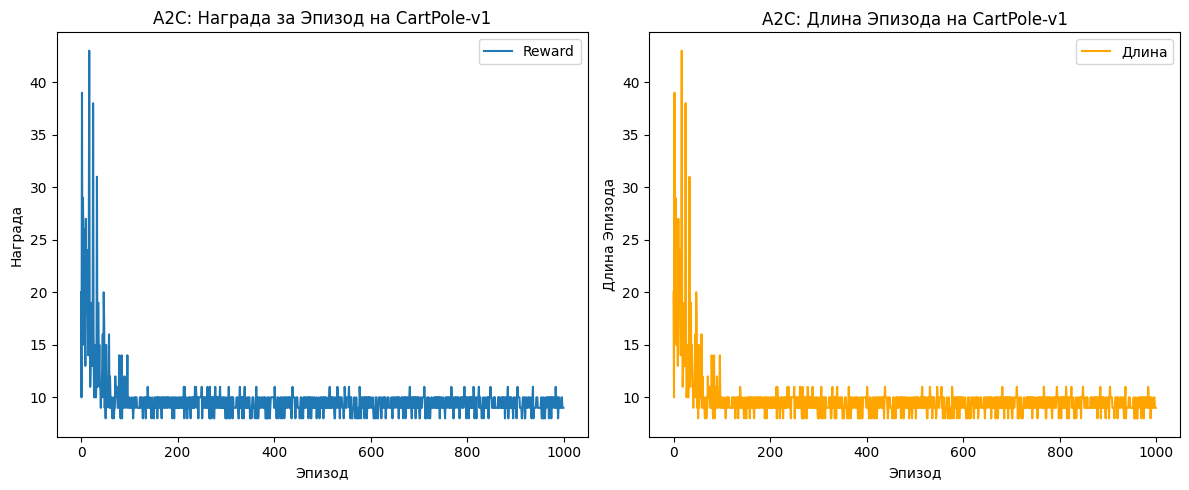

In [63]:
ENV_NAME_DISCRETE = "CartPole-v1"
env_discrete = gym.make(ENV_NAME_DISCRETE)
state_dim_discrete = env_discrete.observation_space.shape[0]
num_actions_discrete = env_discrete.action_space.n
env_discrete.close()


MAX_EPISODES = 1000
ROLLOUT_STEPS = 5
GAMMA = 0.99
LR = 1e-3


net_discrete, rewards_discrete, lengths_discrete = a2c_train_discrete(
    env_name=ENV_NAME_DISCRETE,
    num_actions=num_actions_discrete,
    state_dim=state_dim_discrete,
    max_episodes=MAX_EPISODES,
    rollout_steps=ROLLOUT_STEPS,
    gamma=GAMMA,
    lr=LR
)


save_model_discrete(net_discrete, "model_cartpole.pth")


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(rewards_discrete, label="Reward")
plt.xlabel("Эпизод")
plt.ylabel("Награда")
plt.title("A2C: Награда за Эпизод на CartPole-v1")
plt.legend()

plt.subplot(1,2,2)
plt.plot(lengths_discrete, label="Длина", color="orange")
plt.xlabel("Эпизод")
plt.ylabel("Длина Эпизода")
plt.title("A2C: Длина Эпизода на CartPole-v1")
plt.legend()

plt.tight_layout()
plt.show()

Training Episodes:  10%|██████                                                       | 100/1000 [00:36<05:26,  2.75it/s]

Эпизод: 100, Avg.Reward(100ep): -1416.18, Avg.Length: 200.00


Training Episodes:  20%|████████████▏                                                | 200/1000 [01:14<04:49,  2.76it/s]

Эпизод: 200, Avg.Reward(100ep): -1415.21, Avg.Length: 200.00


Training Episodes:  30%|██████████████████▎                                          | 300/1000 [01:50<04:08,  2.82it/s]

Эпизод: 300, Avg.Reward(100ep): -1389.08, Avg.Length: 200.00


Training Episodes:  40%|████████████████████████▍                                    | 400/1000 [02:26<03:33,  2.81it/s]

Эпизод: 400, Avg.Reward(100ep): -1319.20, Avg.Length: 200.00


Training Episodes:  50%|██████████████████████████████▌                              | 500/1000 [03:02<02:57,  2.81it/s]

Эпизод: 500, Avg.Reward(100ep): -1283.21, Avg.Length: 200.00


Training Episodes:  60%|████████████████████████████████████▌                        | 600/1000 [03:39<02:36,  2.55it/s]

Эпизод: 600, Avg.Reward(100ep): -1359.64, Avg.Length: 200.00


Training Episodes:  70%|██████████████████████████████████████████▋                  | 700/1000 [04:18<01:59,  2.51it/s]

Эпизод: 700, Avg.Reward(100ep): -1208.37, Avg.Length: 200.00


Training Episodes:  80%|████████████████████████████████████████████████▊            | 800/1000 [04:57<01:21,  2.46it/s]

Эпизод: 800, Avg.Reward(100ep): -1320.47, Avg.Length: 200.00


Training Episodes:  90%|██████████████████████████████████████████████████████▉      | 900/1000 [05:36<00:36,  2.71it/s]

Эпизод: 900, Avg.Reward(100ep): -1276.36, Avg.Length: 200.00


Training Episodes: 100%|████████████████████████████████████████████████████████████| 1000/1000 [06:19<00:00,  2.64it/s]

Эпизод: 1000, Avg.Reward(100ep): -1315.03, Avg.Length: 200.00
Модель сохранена в model_pendulum.pth


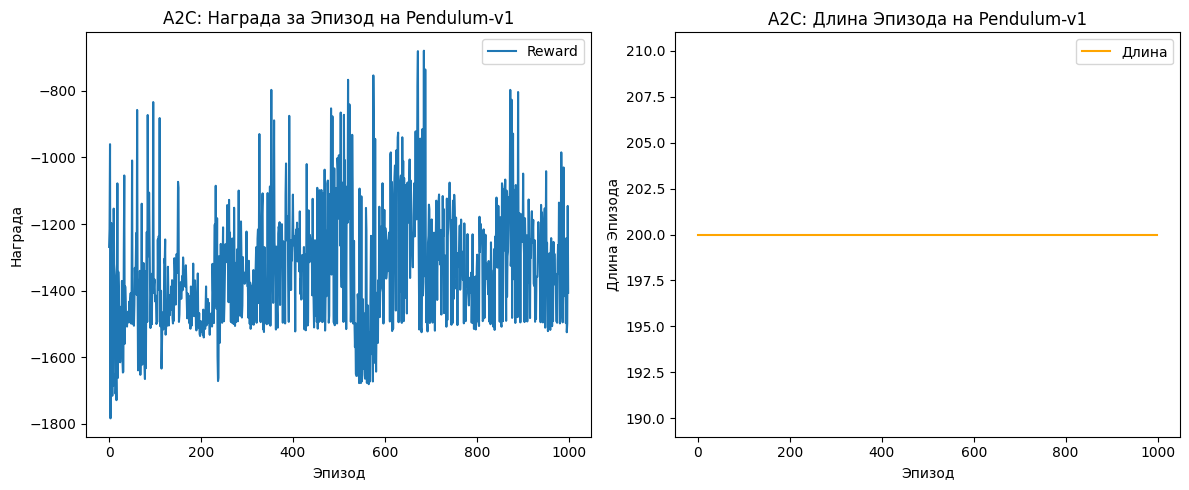

In [64]:
ENV_NAME_CONTINUOUS = "Pendulum-v1"
env_continuous = gym.make(ENV_NAME_CONTINUOUS)
state_dim_continuous = env_continuous.observation_space.shape[0]
num_actions_continuous = env_continuous.action_space.shape[0]
action_bound_continuous = float(env_continuous.action_space.high[0])
env_continuous.close()

MAX_EPISODES = 1000
ROLLOUT_STEPS = 5
GAMMA = 0.99
LR = 1e-3

net_continuous, rewards_continuous, lengths_continuous = a2c_train_continuous(
    env_name=ENV_NAME_CONTINUOUS,
    num_actions=num_actions_continuous,
    state_dim=state_dim_continuous,
    action_bound=action_bound_continuous,
    max_episodes=MAX_EPISODES,
    rollout_steps=ROLLOUT_STEPS,
    gamma=GAMMA,
    lr=LR
)

save_model_continuous(net_continuous, "model_pendulum.pth")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(rewards_continuous, label="Reward")
plt.xlabel("Эпизод")
plt.ylabel("Награда")
plt.title("A2C: Награда за Эпизод на Pendulum-v1")
plt.legend()

plt.subplot(1,2,2)
plt.plot(lengths_continuous, label="Длина", color="orange")
plt.xlabel("Эпизод")
plt.ylabel("Длина Эпизода")
plt.title("A2C: Длина Эпизода на Pendulum-v1")
plt.legend()

plt.tight_layout()
plt.show()


### обученный алгоритм

In [65]:
def test_agent_discrete(env_name, net, num_episodes=100, render=False):
    env = gym.make(env_name)
    net.eval()
    total_rewards = 0
    total_lengths = 0
    
    for episode in trange(num_episodes, desc="Testing Episodes"):
        state, info = env.reset()
        done = False
        truncated = False
        ep_reward = 0.0
        ep_length = 0
        
        while not done and not truncated:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
            with torch.no_grad():
                logits, value = net(state_tensor)
                probs = torch.softmax(logits, dim=-1)
                action = torch.argmax(probs).item()
            
            next_state, reward, done, truncated, info = env.step(action)
            ep_reward += reward
            ep_length += 1
            state = next_state
            
            if render:
                env.render()
        
        total_rewards += ep_reward
        total_lengths += ep_length
    
    env.close()
    avg_reward = total_rewards / num_episodes
    avg_length = total_lengths / num_episodes
    print(f"Средняя награда за {num_episodes} эпизодов: {avg_reward:.2f}, Средняя длина эпизода: {avg_length:.2f}")

In [66]:
def test_agent_continuous(env_name, net, num_episodes=100, render=False):
    env = gym.make(env_name)
    net.eval()
    total_rewards = 0
    total_lengths = 0
    
    for episode in trange(num_episodes, desc="Testing Episodes"):
        state, info = env.reset()
        done = False
        truncated = False
        ep_reward = 0.0
        ep_length = 0
        
        while not done and not truncated:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
            with torch.no_grad():
                mu, std, value = net(state_tensor)
                # Используем среднее значение как действие (детерминированная политика)
                action = mu.cpu().numpy()
            
            # Ограничиваем действие согласно границам среды
            action_clipped = np.clip(action, env.action_space.low, env.action_space.high)
            next_state, reward, done, truncated, info = env.step(action_clipped)
            ep_reward += reward
            ep_length += 1
            state = next_state
            
            if render:
                env.render()
        
        total_rewards += ep_reward
        total_lengths += ep_length
    
    env.close()
    avg_reward = total_rewards / num_episodes
    avg_length = total_lengths / num_episodes
    print(f"Средняя награда за {num_episodes} эпизодов: {avg_reward:.2f}, Средняя длина эпизода: {avg_length:.2f}")


In [67]:
def save_model_discrete(net, filename="model_discrete.pth"):
    torch.save(net.state_dict(), filename)
    print(f"Модель сохранена в {filename}")

def load_model_discrete(state_dim, num_actions, filename="model_discrete.pth"):
    net = ActorCriticNetDiscrete(state_dim, num_actions).to(device)
    net.load_state_dict(torch.load(filename, map_location=device))
    net.eval()
    print(f"Модель загружена из {filename}")
    return net


In [68]:
def save_model_continuous(net, filename="model_continuous.pth"):
    torch.save(net.state_dict(), filename)
    print(f"Модель сохранена в {filename}")

def load_model_continuous(state_dim, num_actions, action_bound, filename="model_continuous.pth"):
    net = ActorCriticNetContinuous(state_dim, num_actions, action_bound).to(device)
    net.load_state_dict(torch.load(filename, map_location=device))
    net.eval()
    print(f"Модель загружена из {filename}")
    return net


In [69]:
ENV_NAME_DISCRETE = "CartPole-v1"
env_discrete = gym.make(ENV_NAME_DISCRETE)
state_dim_discrete = env_discrete.observation_space.shape[0]
num_actions_discrete = env_discrete.action_space.n
env_discrete.close()

net_discrete_loaded = load_model_discrete(state_dim_discrete, num_actions_discrete, "model_cartpole.pth")

test_agent_discrete(
    env_name=ENV_NAME_DISCRETE,
    net=net_discrete_loaded,
    num_episodes=100,
    render=True  
)

/tmp/ipykernel_2107/2926753399.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(filename, map_location=device))


Модель загружена из model_cartpole.pth


/home/ubuntu/myapp/env/lib/python3.12/site-packages/gymnasium/envs/classic_control/cartpole.py:250: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(
Testing Episodes: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 265.29it/s]

Средняя награда за 100 эпизодов: 9.55, Средняя длина эпизода: 9.55


In [70]:
ENV_NAME_CONTINUOUS = "Pendulum-v1"
env_continuous = gym.make(ENV_NAME_CONTINUOUS)
state_dim_continuous = env_continuous.observation_space.shape[0]
num_actions_continuous = env_continuous.action_space.shape[0]
action_bound_continuous = float(env_continuous.action_space.high[0])
env_continuous.close()

net_continuous_loaded = load_model_continuous(state_dim_continuous, num_actions_continuous, action_bound_continuous, "model_pendulum.pth")

test_agent_continuous(
    env_name=ENV_NAME_CONTINUOUS,
    net=net_continuous_loaded,
    num_episodes=100,
    render=True  
)

/tmp/ipykernel_2107/962967882.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(filename, map_location=device))


Модель загружена из model_pendulum.pth


/home/ubuntu/myapp/env/lib/python3.12/site-packages/gymnasium/envs/classic_control/pendulum.py:178: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("Pendulum-v1", render_mode="rgb_array")
  gym.logger.warn(
Testing Episodes: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.24it/s]

Средняя награда за 100 эпизодов: -1265.00, Средняя длина эпизода: 200.00


### необученные

In [71]:
net_discrete_untrained = ActorCriticNetDiscrete(state_dim_discrete, num_actions_discrete).to(device)

In [72]:
test_agent_discrete(
    env_name=ENV_NAME_DISCRETE,
    net=net_discrete_untrained,
    num_episodes=100,
    render=True  
)

Testing Episodes: 100%|██████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 316.99it/s]

Средняя награда за 100 эпизодов: 9.39, Средняя длина эпизода: 9.39


In [73]:
net_continuous_untrained = ActorCriticNetContinuous(state_dim_continuous, num_actions_continuous, action_bound_continuous).to(device)

In [74]:
test_agent_continuous(
    env_name=ENV_NAME_CONTINUOUS,
    net=net_continuous_untrained,
    num_episodes=100,
    render=True  
)

Testing Episodes: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.17it/s]

Средняя награда за 100 эпизодов: -1196.08, Средняя длина эпизода: 200.00


---

по примеру выше видно, что для обученного агента растет время игры.